In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
from PIL import Image
import urllib
import matplotlib.patheffects as path_effects


In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Team Parameters
- Will use home color and away color to implement color gradient (for +ve and -ve rolling xG)
- Then need team logo and id for accessing team data
- Here we're looking at home team's rolling xG - just change these parameters as needed

In [3]:
name = 'Chelsea'

In [4]:
home_colors = {
    'Arsenal': '#E63636',
    'Aston Villa' : '#811331',
    'Brentford' : '#E63636', 
    'Bournemouth' : '#E63636',
    'Brighton': '#2d8ce7',
    'Chelsea' : '#2D5DE7',
    'Crystal Palace' : '#E63636',
    'Everton' : '#2D5DE7', 
    'Fulham' : '#9C9C9C', 
    'Leeds' : '#9C9C9C', 
    'Leicester' : '#2d8ce7',
    'Liverpool' : '#E63636',
    'Nottingham Forest' : '#E63636',
    'Newcastle' : '#9C9C9C',
    'Man Utd' : '#E63636',
    'Man City' : '#6FC6E6',
    'Southampton' : '#E63636',
    'Tottenham' : '#9C9C9C', 
    'West Ham' : '#811331',
    'Wolves' : '#DA9D0A'
}

away_colors = {
    'Arsenal': '#757474',
    'Aston Villa' : '#6FC6E6',
    'Brentford' : '#6FC6E6', 
    'Bournemouth' : '#757474',
    'Brighton': '#FB6B07',
    'Chelsea' : '#9C9C9C', 
    'Crystal Palace' : '#9C9C9C', 
    'Everton' : '#C571FA', 
    'Fulham' : '#5FE347', 
    'Leeds' : '#b4b400', 
    'Leicester' : '#757474',
    'Liverpool' : '#9C9C9C', 
    'Nottingham Forest' : '#b4b400',
    'Newcastle' : '#0202C4',
    'Man Utd' : '#9C9C9C',
    'Man City' : '#757474',
    'Southampton' : '#2d8ce7',
    'Tottenham' : '#C571FA', 
    'West Ham' : '#757474',
    'Wolves' : '#066D49'
}

# Adding third color since grey can be a bit too neutral given the background
third_colors = {
    'Arsenal': '#0052b8',
    'Aston Villa' : '#757474',
    'Brentford' : '#757474',
    'Bournemouth' : '#008545',
    'Brighton': '#5FE347', 
    'Chelsea' : '#C5C5AD',
    'Crystal Palace' : '#2D5DE7',
    'Everton' : '#b4b400',
    'Fulham' : '#5FE347',
    'Leeds' : '#757474',
    'Leicester' : '#C5C5AD',
    'Liverpool' : '#008545',
    'Nottingham Forest' : '#0052b8',
    'Newcastle' : '#FB6B07',
    'Man Utd' : '#b4b400',
    'Man City' : '#E63636',
    'Southampton' : '#008545',
    'Tottenham' : '#2d8ce7',
    'West Ham' : '#0052b8',
    'Wolves' : '#9C9C9C'
}

In [5]:
logos = {
    'Arsenal': 9825,
    'Aston Villa' : 10252,
    'Brentford' : 9937, 
    'Bournemouth' : 8678, 
    'Brighton': 10204,
    'Chelsea' : 8455,
    'Crystal Palace' : 9826, 
    'Everton' : 8668, 
    'Fulham' : 9879, 
    'Leeds' : 8463, 
    'Leicester' : 8197,
    'Liverpool' : 8650,
    'Nottingham Forest' : 10203,
    'Newcastle' : 10261,
    'Man Utd' : 10260,
    'Man City' : 8456,
    'Southampton' : 8466,
    'Tottenham' : 8586, 
    'West Ham' : 8654,
    'Wolves' : 8602
}


In [6]:
mapping = {
            'Arsenal': 13,
            'Aston Villa' : 24,
            'Brentford' : 189, 
            'Bournemouth' : 183,
            'Brighton': 211,
            'Chelsea' : 15,
            'Crystal Palace' : 162,
            'Everton' : 31, 
            'Fulham' : 170, 
            'Leeds' : 19, 
            'Leicester' : 14,
            'Liverpool' : 26,
            'Nottingham Forest' : 174,
            'Newcastle' : 23,
            'Man Utd' : 32,
            'Man City' : 167,
            'Southampton' : 18,
            'Tottenham' : 30, 
            'West Ham' : 29,
            'Wolves' : 161
        }



In [7]:
color_1 = away_colors[name]
if color_1 == '#9C9C9C' or color_1 == '#757474':
    color_1 = third_colors[name]
color_2 = home_colors[name]

team_code = logos[name]

teamID = mapping[name]

## Color Gradient Function
- For plotting purposes

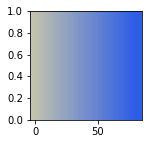

In [8]:
def colorFader(c1,c2,mix=0): 
    c1=np.array(mcolors.to_rgb(c1))
    c2=np.array(mcolors.to_rgb(c2))
    
    return mcolors.to_hex((1-mix)*c1 + mix*c2)

# For our Examplen=83
n=83
fig, ax = plt.subplots(figsize=(2, 2))
for x in range(n+1):
    ax.axvline(x, color=colorFader(color_1,color_2,x/n), linewidth=10) 
plt.show()

## Import our Season Match Data
- Keep all games involving our team
- So we can compare this game

In [9]:
df1 = pd.read_csv('pl_2223_FirstHalf.csv').iloc[:,1:]
matches1 = df1[df1['teamId'] == teamID]['matchId'].unique()

df2 = pd.read_csv('pl_2223_SecondHalf.csv').iloc[:,1:]
matches2 = df2[df2['teamId'] == teamID]['matchId'].unique()

In [10]:
df1 = df1[df1['matchId'].isin(matches1)].reset_index(drop=True)
df2 = df2[df2['matchId'].isin(matches2)].reset_index(drop=True)

## xG Functions
- Need to calculate npxG and npxGA for our team
- Will loop games over our functions which calculate xG according to our own xG model (see xG model for more info here)

In [11]:
# Info needed for function/our xg model

pitch_length_x = 100
pitch_length_y = 100

feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
                'bigChanceMissed',
                'bigChanceScored',
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]



In [12]:
def xg_calc(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    df_shots = df_shots.reset_index(drop=True)
    
    X_game = df_shots.iloc[:, 10:]
    Y_game = df_shots['isGoal']
    
    # Import our xG model 
    xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))
    
    
    y_pred_game = xg_model.predict_proba(X_game)
    df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
    df_pred_game = pd.merge(df_shots, df_pred_game, left_index=True, right_index=True).reset_index(drop=True)

    
    return df_pred_game.groupby(['teamId'])['prob_goal'].sum()
 

##  Calculate xG values 
- Just loop our matches over the xG function which we defined above

In [13]:
npxg = []
npxga = []

for match_id in matches1:
    df = df1[df1['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != teamID][0]
    
    xg = xg_calc(df)
    xg_create = xg[teamID]
    xg_allow = xg[opp_id]
    
    npxg.append(xg_create)
    npxga.append(xg_allow)
    
for match_id in matches2:
    df = df2[df2['matchId'] == match_id].reset_index(drop=True)
    ids = df['teamId'].unique()
    opp_id = [id_ for id_ in ids if id_ != teamID][0]
    
    xg = xg_calc(df)
    xg_create = xg[teamID]
    xg_allow = xg[opp_id]
    
    npxg.append(xg_create)
    npxga.append(xg_allow)

In [14]:
df_xg = pd.DataFrame({'npxg':npxg, 'npxga':npxga})
df_xg['rolling_npxg'] = df_xg['npxg'].rolling(window=5, min_periods=0).mean()
df_xg['rolling_npxga'] = df_xg['npxga'].rolling(window=5, min_periods=0).mean()
df_xg['rolling_npxg_diff'] = df_xg['rolling_npxg'] - df_xg['rolling_npxga']
df_xg

,npxg,npxga,rolling_npxg,rolling_npxga,rolling_npxg_diff
0,1.189448,0.457762,1.189448,0.457762,0.731686
1,1.664924,1.390460,1.427186,0.924111,0.503075
2,0.736348,2.163158,1.196907,1.337127,-0.140220
3,1.858198,2.194554,1.362229,1.551484,-0.189254
4,1.263517,1.075118,1.342487,1.456211,-0.113724
5,1.024032,1.028496,1.309404,1.570357,-0.260953
6,1.152788,0.708471,1.206977,1.433959,-0.226983
7,2.300542,0.831610,1.519816,1.167650,0.352166
8,1.578720,2.004248,1.463920,1.129589,0.334331
9,0.652827,1.270639,1.341782,1.168693,0.173089


In [15]:
df_xg['match_number'] = df_xg.index
X_aux = df_xg.match_number.copy()
X_aux.index = X_aux * 50 # 9 aux points in between each match
last_idx = X_aux.index[-1] + 1
X_aux = X_aux.reindex(range(last_idx))
X_aux = X_aux.interpolate()

# Aux Series for xG created
Y_for_aux = df_xg['rolling_npxg'].copy()
Y_for_aux.index = Y_for_aux.index * 50
last_idx = Y_for_aux.index[-1] + 1
Y_for_aux = Y_for_aux.reindex(range(last_idx))
Y_for_aux = Y_for_aux.interpolate()

# Aux Series for xG conceded
Y_ag_aux = df_xg['rolling_npxga'].copy()
Y_ag_aux.index = Y_ag_aux.index * 50
last_idx = Y_ag_aux.index[-1] + 1
Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
Y_ag_aux = Y_ag_aux.interpolate()

# Aux Series for Rolling xG
Z_diff_aux = df_xg['rolling_npxg_diff'].copy()
Z_diff_aux.index = Z_diff_aux.index * 50
last_idx = Z_diff_aux.index[-1] + 1
Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
Z_diff_aux = Z_diff_aux.interpolate()

df_aux_xg = pd.DataFrame({
                            'X': X_aux,
                            'Y_for': Y_for_aux,
                            'Y_ag': Y_ag_aux,
                            'Z': Z_diff_aux
})

In [16]:
df_aux_xg

,X,Y_for,Y_ag,Z
0,0.00,1.189448,0.457762,0.731686
1,0.02,1.194203,0.467089,0.727114
2,0.04,1.198958,0.476416,0.722541
3,0.06,1.203712,0.485743,0.717969
4,0.08,1.208467,0.495070,0.713397
...,...,...,...,...
1446,28.92,1.482704,1.093547,0.389156
1447,28.94,1.480137,1.092791,0.387346
1448,28.96,1.477571,1.092036,0.385535
1449,28.98,1.475004,1.091280,0.383724


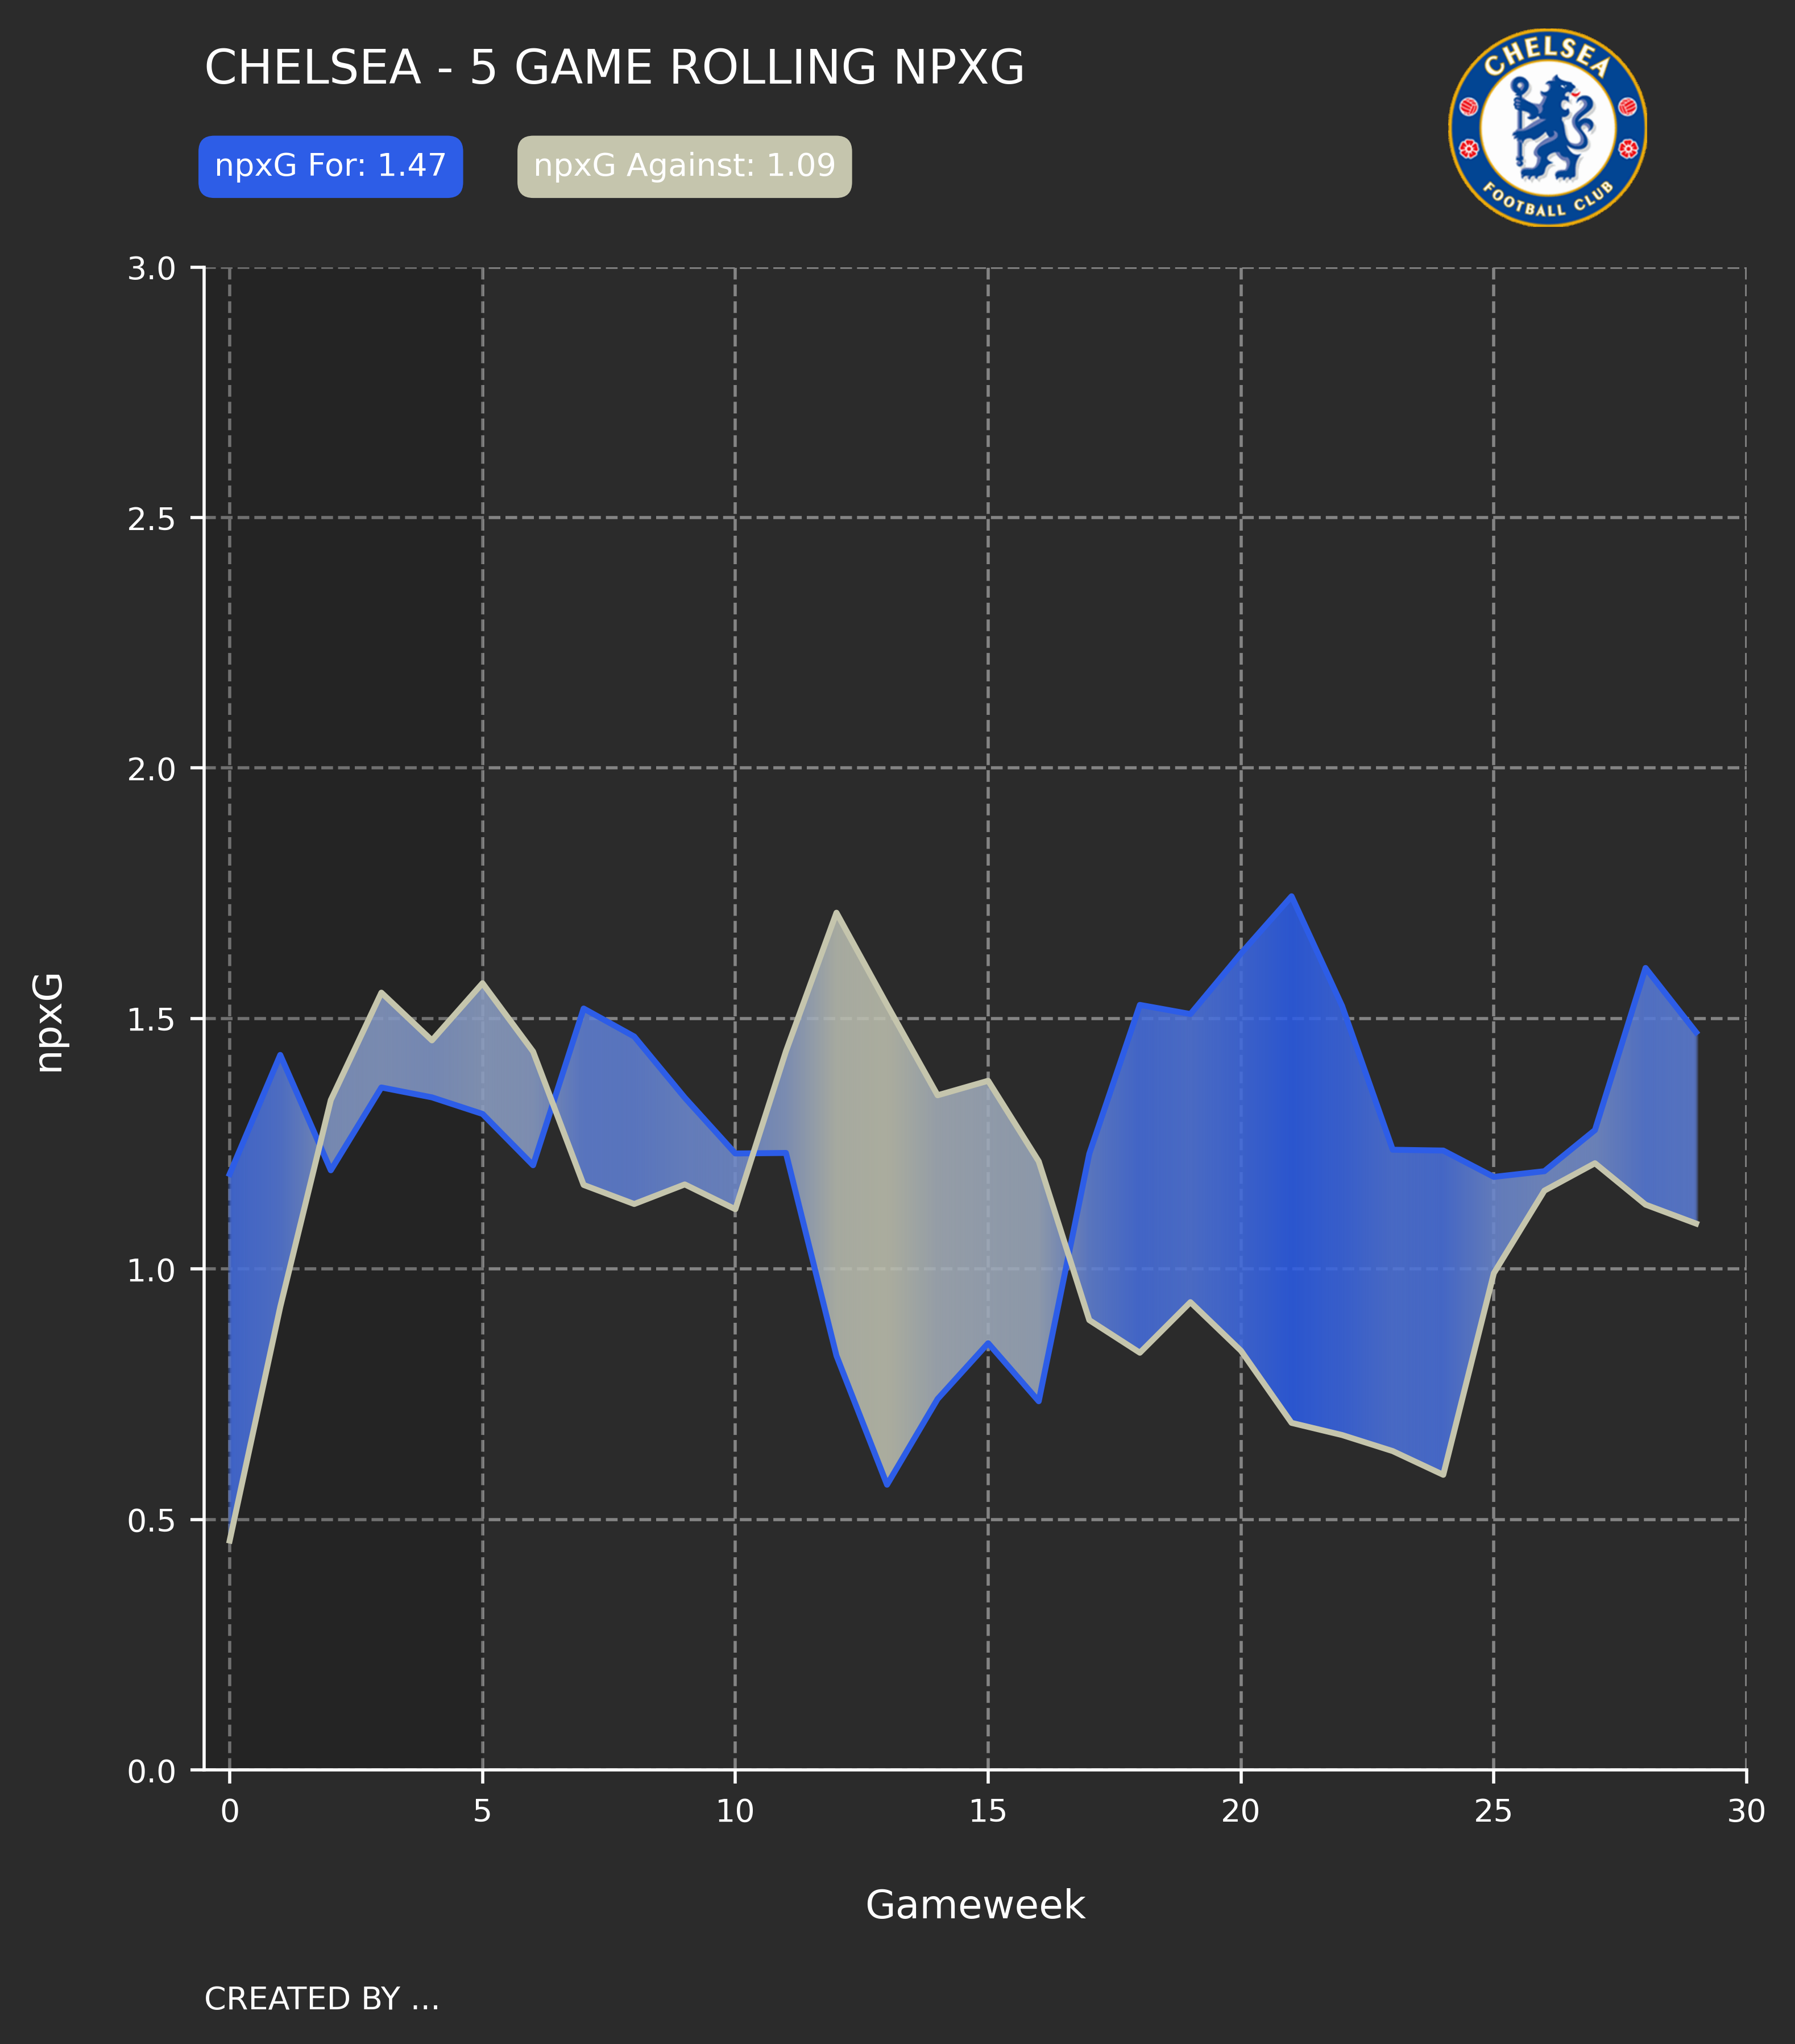

In [18]:
fig = plt.figure(figsize = (7,7), dpi = 500)
ax = plt.subplot(111)
fig.set_facecolor("#2B2B2B")
ax.set_facecolor("#2B2B2B")

ax.set_ylim(0,3)
ax.set_xlim(-0.5,df_xg.shape[0])
# ax.grid(ls='--', color='lightgrey')

ax.set_axisbelow(True)
ax.yaxis.grid(color='#848484', linestyle='dashed')
ax.xaxis.grid(color='#848484', linestyle='dashed')
# spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('w')
ax.spines['bottom'].set_color('w')
# ticks
for tick in ax.xaxis.get_ticklines(): 
    tick.set_color('w')
for tick in ax.yaxis.get_ticklines(): 
    tick.set_color('w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.tick_params(axis='x', colors='white')    
ax.tick_params(axis='y', colors='white')   


ax.plot(df_xg.index, df_xg['rolling_npxg'], color=color_2,zorder=4)
ax.plot(df_xg.index, df_xg['rolling_npxga'], color=color_1,zorder=4)
ax.fill_between(x=[-0.5,5], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], alpha=0.15, color='black', ec='None',zorder=2)
vmin = df_xg['rolling_npxg_diff'].min()
vmax = df_xg['rolling_npxg_diff'].max()
vmax = max(abs(vmin), abs(vmax))
vmin = -1*vmax
for i in range(0, len(df_aux_xg['X']) - 1):
    ax.fill_between(
        [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
        [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i + 1]],
        [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i + 1]],
        color=colorFader(color_1, color_2, mix=((df_aux_xg['Z'].iloc[i] - vmin)/(vmax - vmin))),
        zorder=3, alpha=0.3
    )
    
plt.title(name.upper() + ' - 5 game rolling npxG'.upper() + '\n\n\n', 
          loc='left', color='w', fontname = 'Sans Serif', fontsize = 12, y=1)
plt.xlabel('\nGameweek', color='w', fontsize=10)
plt.ylabel('npxG\n', color='w', fontsize=10)

plt.figtext(0.125, 0.005, "CREATED BY ...", ha="left", fontsize=8, fontname='Sans Serif', color='white')

# Logo
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = team_code
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax2 = fig.add_axes([0.75, 0.9, 0.10, 0.10], anchor='NE', zorder=2)
newax2.imshow(club_icon)
newax2.axis('off')


# Box
xG_for = df_xg['rolling_npxg'].iloc[-1]
xG_ag = df_xg['rolling_npxga'].iloc[-1]
ax.annotate(text='npxG For: ' + str(round(xG_for,2)), xytext=(2, 3.2), xy=(0, 0), 
            ha='center', va='center', color='white',
            bbox=dict(facecolor=color_2, edgecolor='none', boxstyle='round,pad=.5'),
            fontname = 'Sans Serif', fontsize=8)
ax.annotate(text='npxG Against: ' + str(round(xG_ag,2)), xytext=(9, 3.2), xy=(0, 0), 
            ha='center', va='center', color='white',
            bbox=dict(facecolor=color_1, edgecolor='none', boxstyle='round,pad=.5'),
            fontname = 'Sans Serif', fontsize=8)


fig.savefig('rolling_npxg.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=1000)

